# 2. PHẦN MÔ HÌNH TRỘN GAUSSIAN (GAUSSIAN MIXTURE MODEL)

In [78]:
import numpy as np
from numpy import random
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import multivariate_normal

class GMM():
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        input:
            - k: Number of Gaussian clusters
            - dim: Dimension 
            - init_mu: initial value of mean of clusters (k, dim)
                       (default) random from uniform[-10, 10]
            - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
                          (default) Identity matrix for each cluster
            - init_pi: initial value of cluster weights (k,)
                       (default) equal value to all cluster i.e. 1/k
            - colors: Color valu for plotting each cluster (k, 3)
                      (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        if(init_mu is None):
            init_mu = random.rand(k, dim)*20 - 10
        self.mu = init_mu
        if(init_sigma is None):
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        if(init_pi is None):
            init_pi = np.ones(self.k)/self.k
        self.pi = init_pi
        if(colors is None):
            colors = random.rand(k, 3)
            for i in range(k):
                colors[i, 2] = i/k
        self.colors = colors
    
    def init_em(self, X):
        '''
        Initialization for EM algorithm.
        input:
            - X: data (batch_size, dim)
        '''
        self.data = X
        self.num_points = X.shape[0]
        self.z = np.zeros((self.num_points, self.k))
    
    def e_step(self):
        '''
        E-step of EM algorithm.
        '''
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.num_points
        self.mu = np.matmul(self.z.T, self.data)
        self.mu /= sum_z[:, None]
        for i in range(self.k):
            j = np.expand_dims(self.data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            
    def log_likelihood(self, X):
        '''
        Compute the log-likelihood of X under current parameters
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of X: Sum_n Sum_k log(pi_k * N( X_n | mu_k, sigma_k ))
        '''
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mu[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)
    
    def plot_gaussian(self, mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):
        '''
        Utility function to plot one Gaussian from mean and covariance.
        '''
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0),
            width=ell_radius_x * 2,
            height=ell_radius_y * 2,
            facecolor=facecolor,
            **kwargs)
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = mean[0]
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = mean[1]
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)

    def draw(self, ax, n_std=2.0, facecolor='none', **kwargs):
        '''
        Function to draw the Gaussians.
        Note: Only for two-dimensionl dataset
        '''
        if(self.dim != 2):
            print("Drawing available only for 2D case.")
            return
        for i in range(self.k):
            self.plot_gaussian(self.mu[i], self.sigma[i], ax, n_std=n_std, edgecolor=self.colors[i], **kwargs)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [80]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.
    Will also plot the points in case of 2D.
    input:
        - k: Number of Gaussian clusters
        - dim: Dimension of generated points
        - points_per_cluster: Number of points to be generated for each cluster
        - lim: Range of mean values
    output:
        - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    mean = random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True) 
    return x

In [81]:
def plot(title):
    '''
    Draw the data points and the fitted mixture model.
    input:
        - title: title of plot and name with which it will be saved.
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ax.scatter(X[:, 0], X[:, 1], s=3, alpha=0.4)
    ax.scatter(gmm.mu[:, 0], gmm.mu[:, 1], c=gmm.colors)
    gmm.draw(ax, lw=3)
    ax.set_xlim((-22, 22))
    ax.set_ylim((-22, 22))
    
    plt.title(title)
    plt.savefig(title.replace(':', '_'))
    plt.show()
    plt.clf()

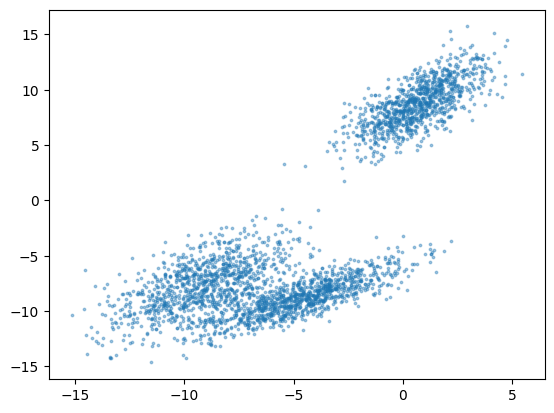

In [82]:
# Generate random 2D data with 3 clusters 
X = gen_data(k=3, dim=2, points_per_cluster=1000)

In [83]:
# Create a Gaussian Mixture Model
gmm = GMM(3, 2)

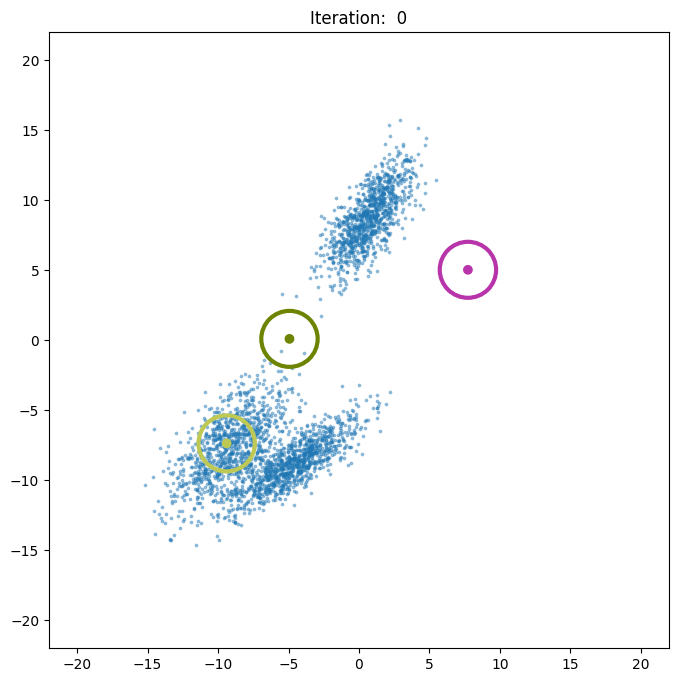

Iteration: 1, log-likelihood: -15251.5565


<Figure size 640x480 with 0 Axes>

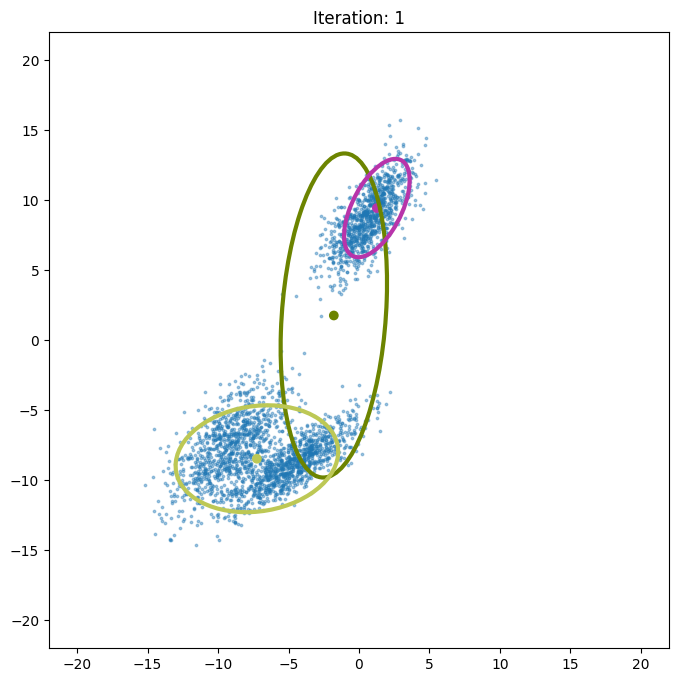

Iteration: 2, log-likelihood: -15088.4020


<Figure size 640x480 with 0 Axes>

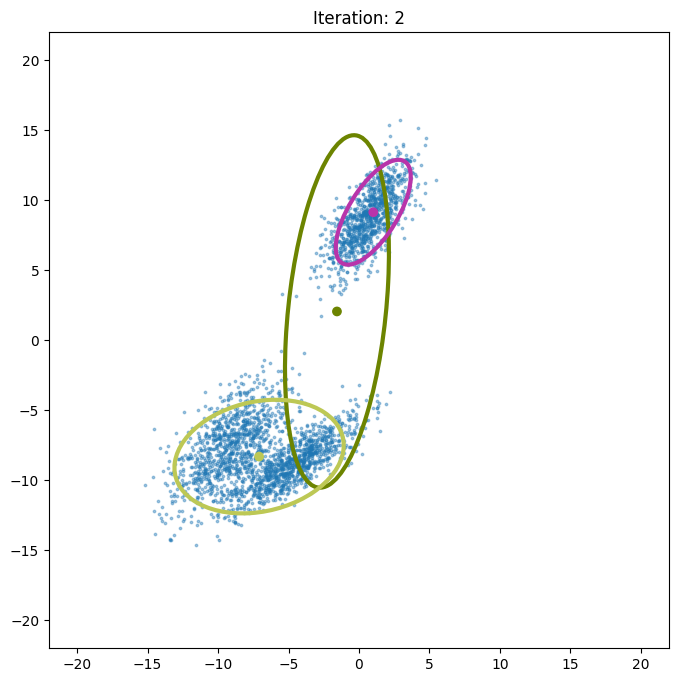

Iteration: 3, log-likelihood: -15022.2829


<Figure size 640x480 with 0 Axes>

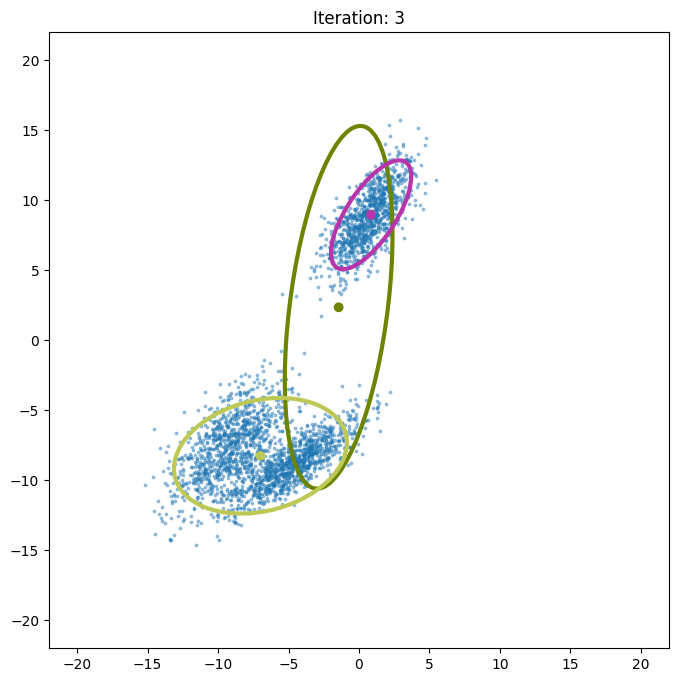

Iteration: 4, log-likelihood: -14990.0260


<Figure size 640x480 with 0 Axes>

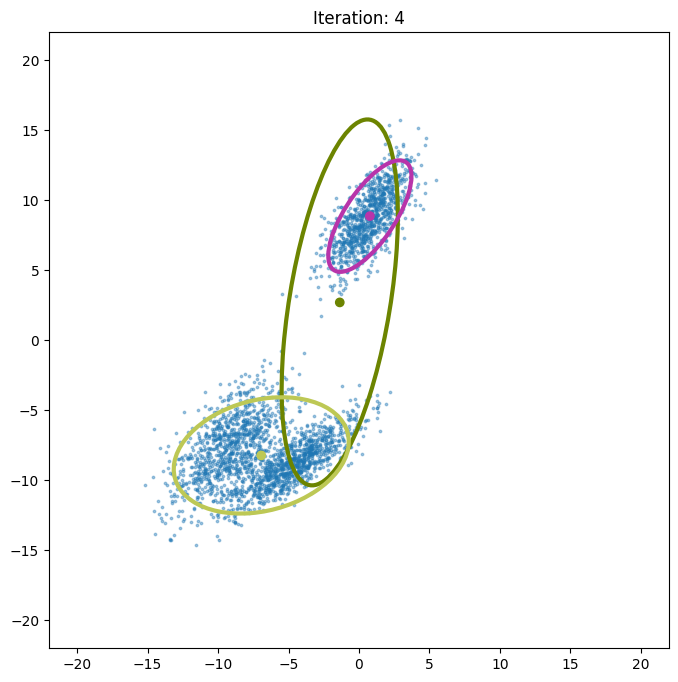

Iteration: 5, log-likelihood: -14973.3714


<Figure size 640x480 with 0 Axes>

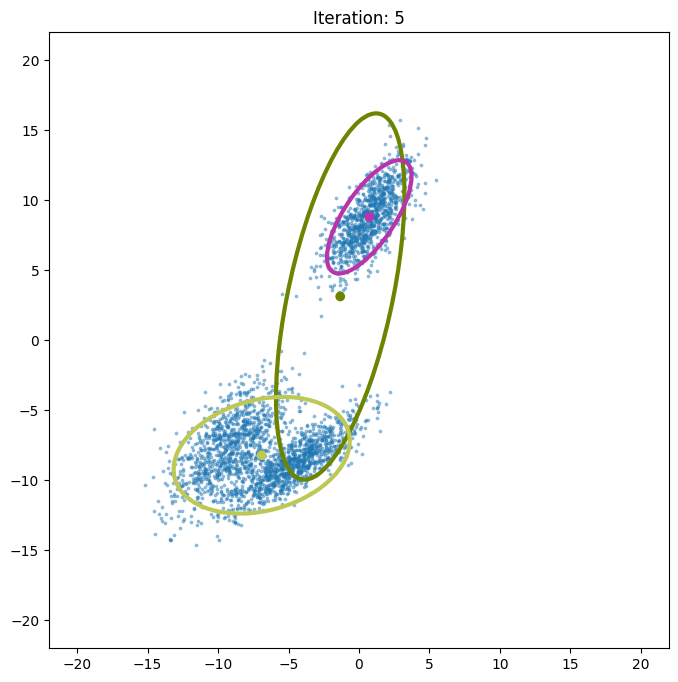

Iteration: 6, log-likelihood: -14964.2700


<Figure size 640x480 with 0 Axes>

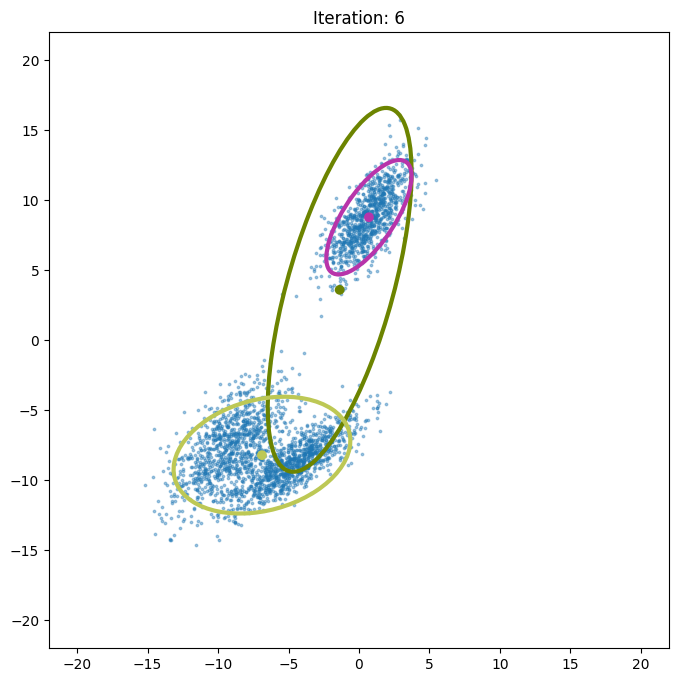

Iteration: 7, log-likelihood: -14958.8250


<Figure size 640x480 with 0 Axes>

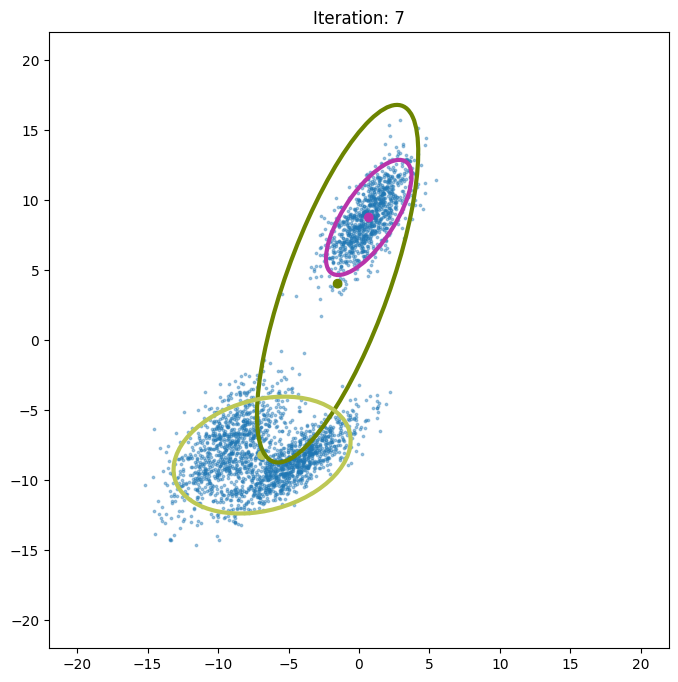

Iteration: 8, log-likelihood: -14955.0958


<Figure size 640x480 with 0 Axes>

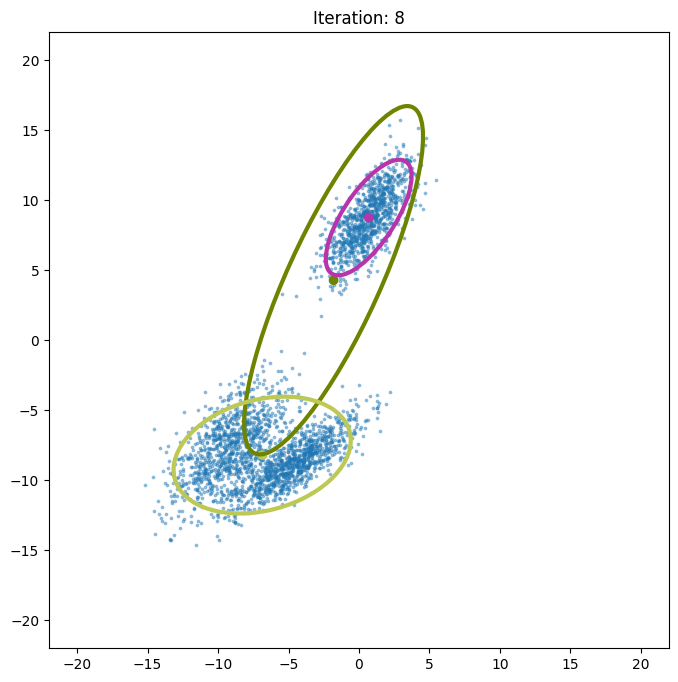

Iteration: 9, log-likelihood: -14952.4878


<Figure size 640x480 with 0 Axes>

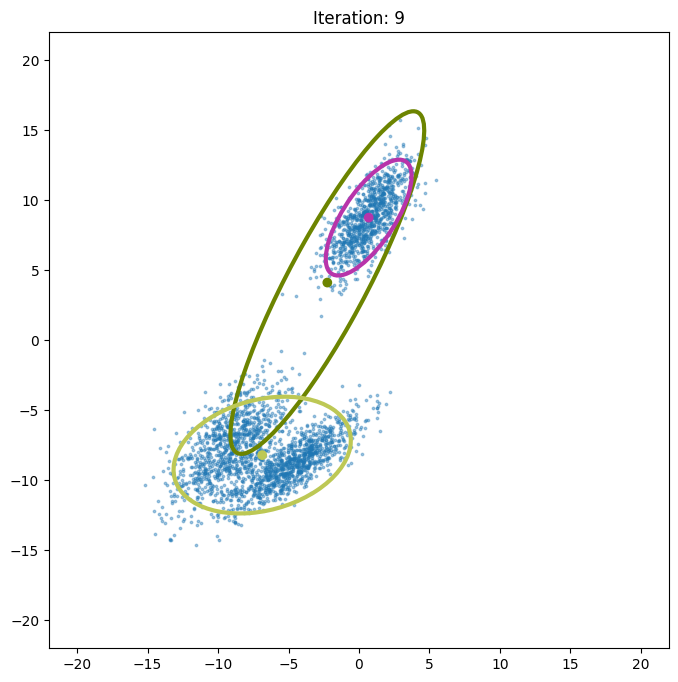

Iteration: 10, log-likelihood: -14950.7498


<Figure size 640x480 with 0 Axes>

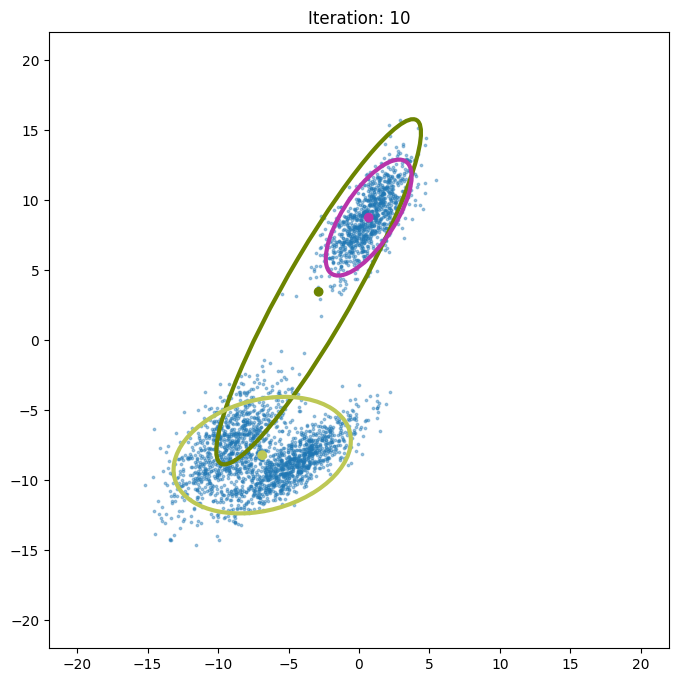

Iteration: 11, log-likelihood: -14949.1660


<Figure size 640x480 with 0 Axes>

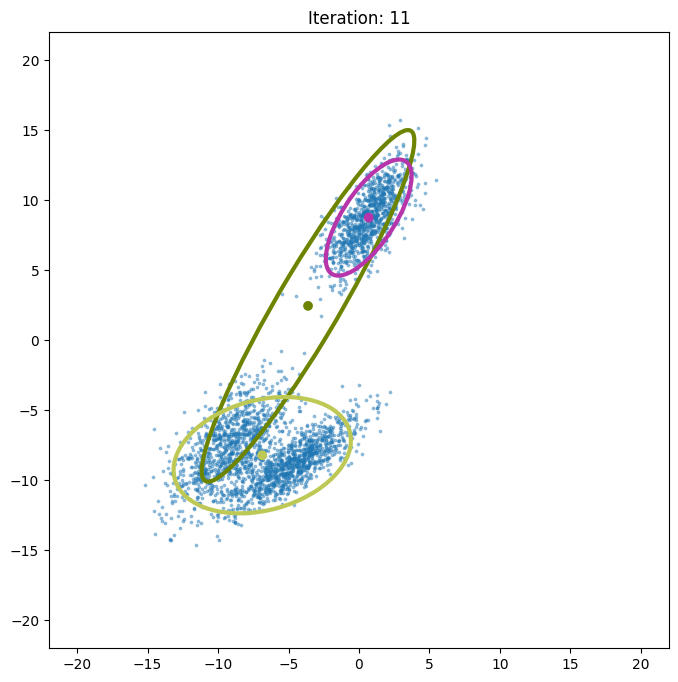

Iteration: 12, log-likelihood: -14947.3381


<Figure size 640x480 with 0 Axes>

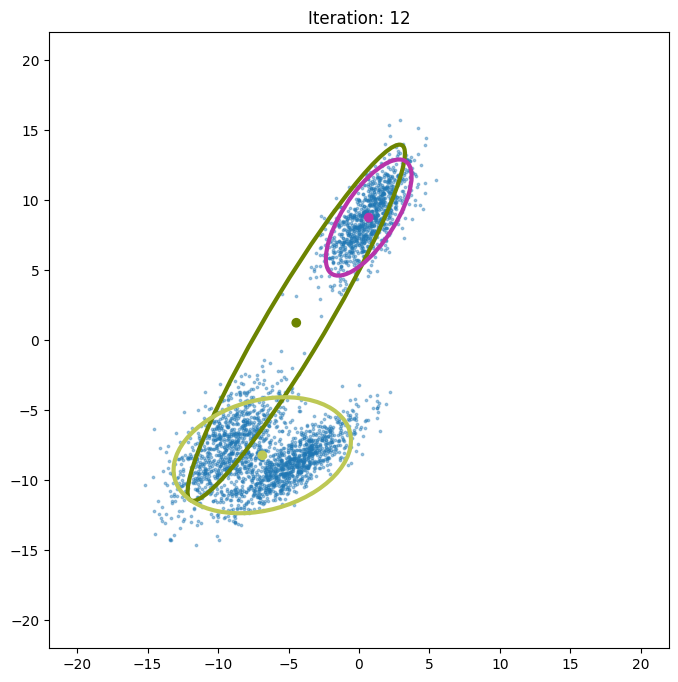

Iteration: 13, log-likelihood: -14945.0638


<Figure size 640x480 with 0 Axes>

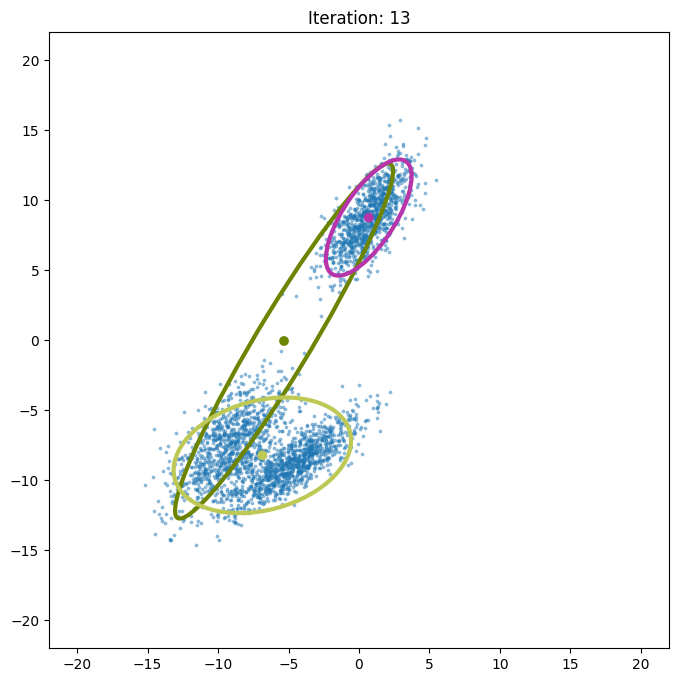

Iteration: 14, log-likelihood: -14942.1330


<Figure size 640x480 with 0 Axes>

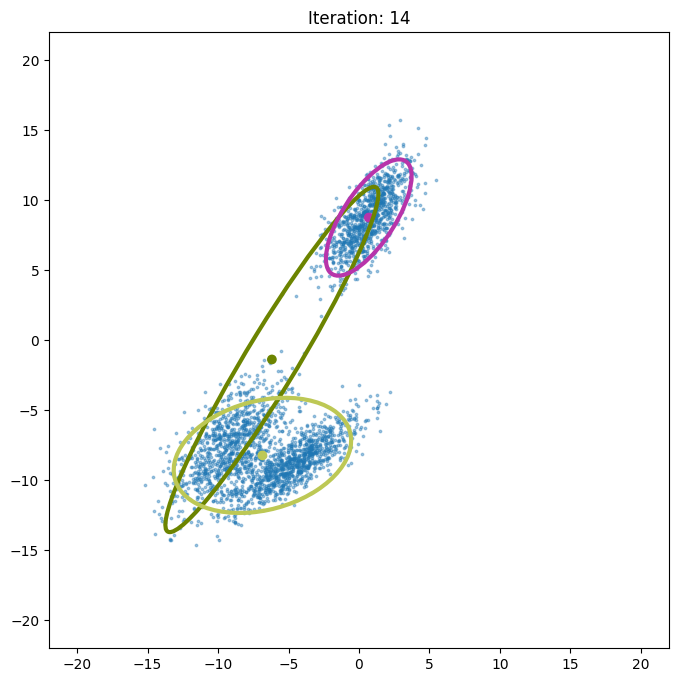

Iteration: 15, log-likelihood: -14938.1915


<Figure size 640x480 with 0 Axes>

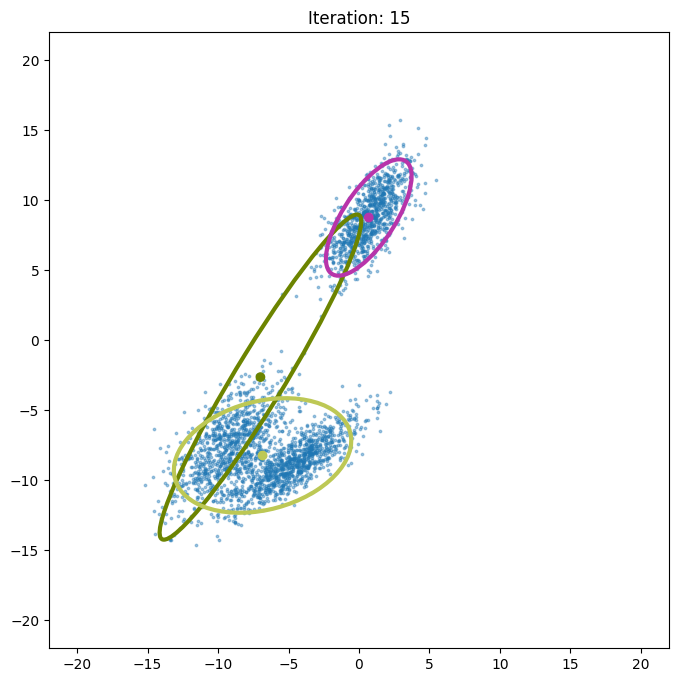

Iteration: 16, log-likelihood: -14932.5870


<Figure size 640x480 with 0 Axes>

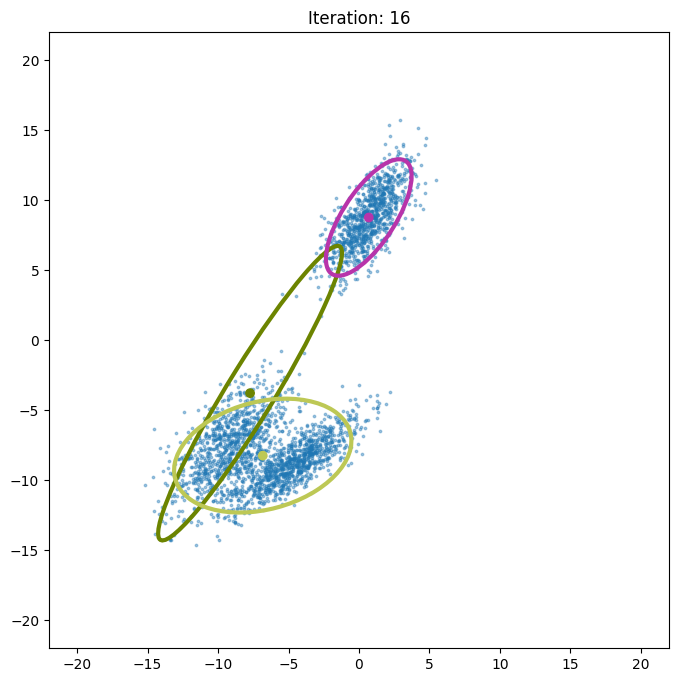

Iteration: 17, log-likelihood: -14924.3979


<Figure size 640x480 with 0 Axes>

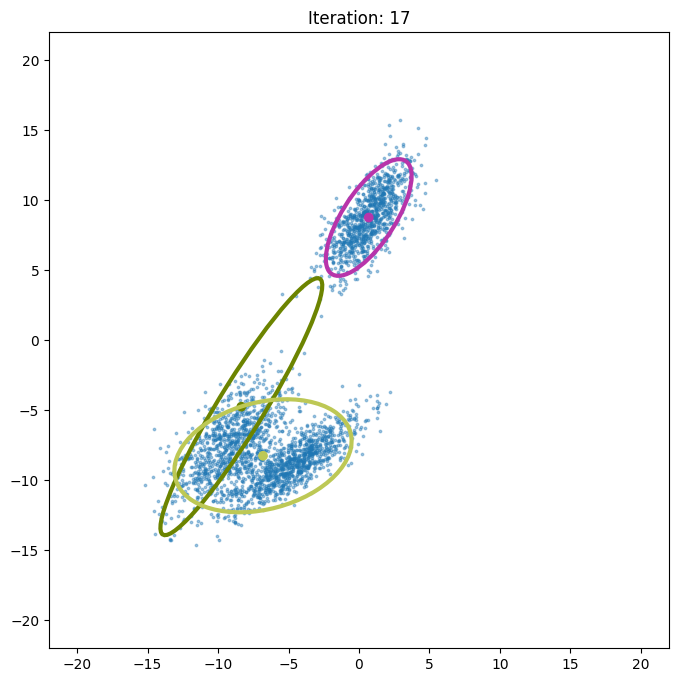

Iteration: 18, log-likelihood: -14913.1757


<Figure size 640x480 with 0 Axes>

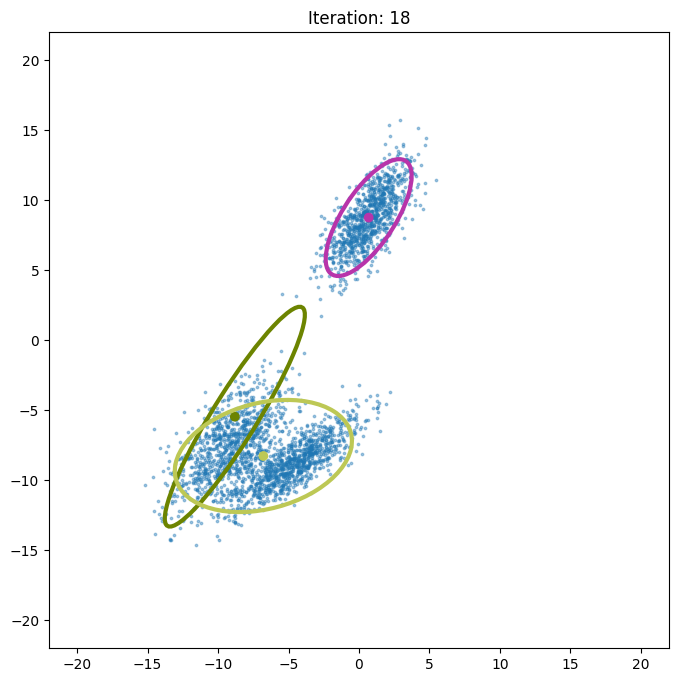

Iteration: 19, log-likelihood: -14899.7715


<Figure size 640x480 with 0 Axes>

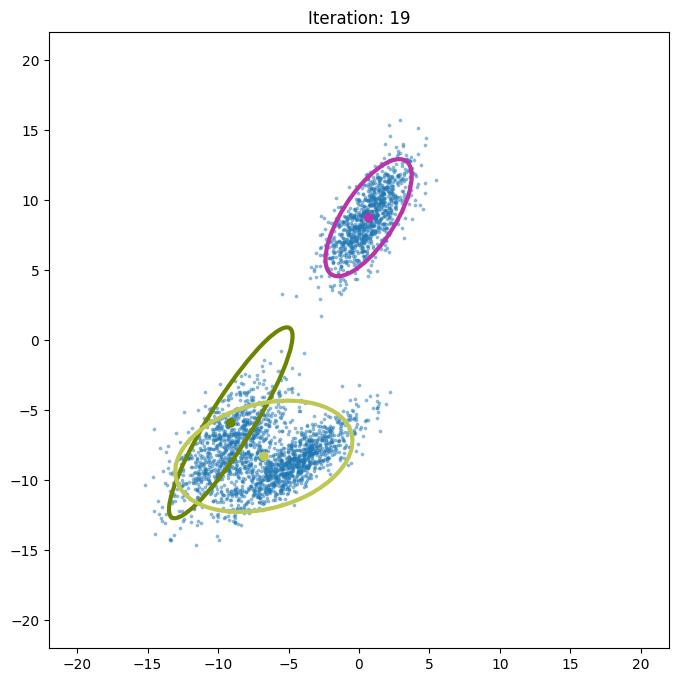

Iteration: 20, log-likelihood: -14885.3336


<Figure size 640x480 with 0 Axes>

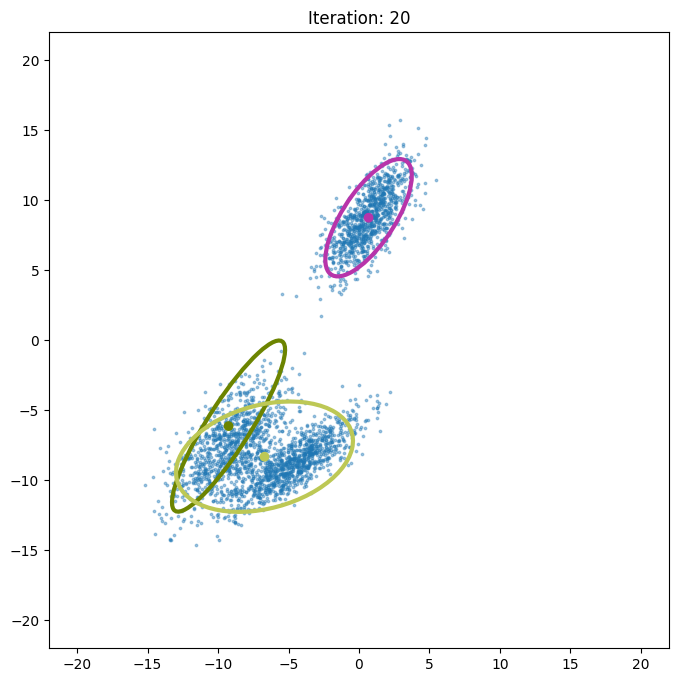

<Figure size 640x480 with 0 Axes>

In [84]:
# Training the GMM using EM

# Initialize EM algo with data
gmm.init_em(X)

num_iters = 20
# Saving log-likelihood
log_likelihood = [gmm.log_likelihood(X)]
# plotting
plot("Iteration:  0")
for e in range(num_iters):
    # E-step
    gmm.e_step()
    # M-step
    gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.log_likelihood(X))
    print("Iteration: {}, log-likelihood: {:.4f}".format(e+1, log_likelihood[-1]))
    # plotting
    plot(title="Iteration: " + str(e+1))

### Bài tập tự thực hành 1: Sử dụng đoạn code trên để áp dựng cho dữ liệu là phần đầu vào của tập dữ liệu hoa Iris (bỏ trường tên loại hoa). Sau khi phân cụm xong hãy đối sánh kết quả với các phân loại đúng.

In [85]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal, mode
import matplotlib.pyplot as plt


###### Load dữ liệu & Chuẩn hoá

In [86]:
iris = datasets.load_iris()
X = iris.data
y_true = iris.target

scaler = StandardScaler()
X_std = scaler.fit_transform(X)


###### 3) Cài đặt lớp GMM-EM Khởi tạo + E-step + M-step + log-likelihood + điều kiện hội tụ

In [87]:
class GMM_EM:
    def __init__(self, k, X, max_iter=200, tol=1e-4):
        self.k = k
        self.X = X
        self.n, self.d = X.shape
        self.max_iter = max_iter
        self.tol = tol

        # Khởi tạo tốt bằng KMeans
        kmeans = KMeans(n_clusters=k, n_init=10).fit(X)
        self.mu = kmeans.cluster_centers_
        self.pi = np.ones(k) / k
        self.sigma = np.array([np.eye(self.d) for _ in range(k)])
        self.z = np.zeros((self.n, k))

    def e_step(self):
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(
                self.X, mean=self.mu[i], cov=self.sigma[i], allow_singular=True
            )
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self):
        Nk = self.z.sum(axis=0)
        self.pi = Nk / self.n
        self.mu = (self.z.T @ self.X) / Nk[:, None]

        for i in range(self.k):
            diff = self.X - self.mu[i]
            self.sigma[i] = (self.z[:, i][:, None] * diff).T @ diff / Nk[i]
            self.sigma[i] += np.eye(self.d) * 1e-6  # chống singular

    def log_likelihood(self):
        ll = 0
        for i in range(self.k):
            ll += self.pi[i] * multivariate_normal.pdf(
                self.X, mean=self.mu[i], cov=self.sigma[i], allow_singular=True
            )
        return np.sum(np.log(ll))

    def fit(self):
        prev_ll = None
        for iteration in range(self.max_iter):
            self.e_step()
            self.m_step()

            ll = self.log_likelihood()
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                print(f"Converged at iteration {iteration}")
                break
            prev_ll = ll

    def predict(self):
        return np.argmax(self.z, axis=1)



###### Train mô hình

In [88]:
gmm = GMM_EM(k=3, X=X_std)
gmm.fit()

y_pred = gmm.predict()


Converged at iteration 22


###### Ánh xạ nhãn cụm với nhãn thật

In [89]:
def align_labels(y_pred, y_true):
    y_aligned = np.zeros_like(y_pred)
    for i in range(3):
        mask = (y_pred == i)
        y_aligned[mask] = mode(y_true[mask])[0]
    return y_aligned

y_aligned = align_labels(y_pred, y_true)
acc = accuracy_score(y_true, y_aligned)

print("Độ chính xác GMM:", acc)


Độ chính xác GMM: 0.9666666666666667


###### Vẽ biểu đồ phân cụm với PCA

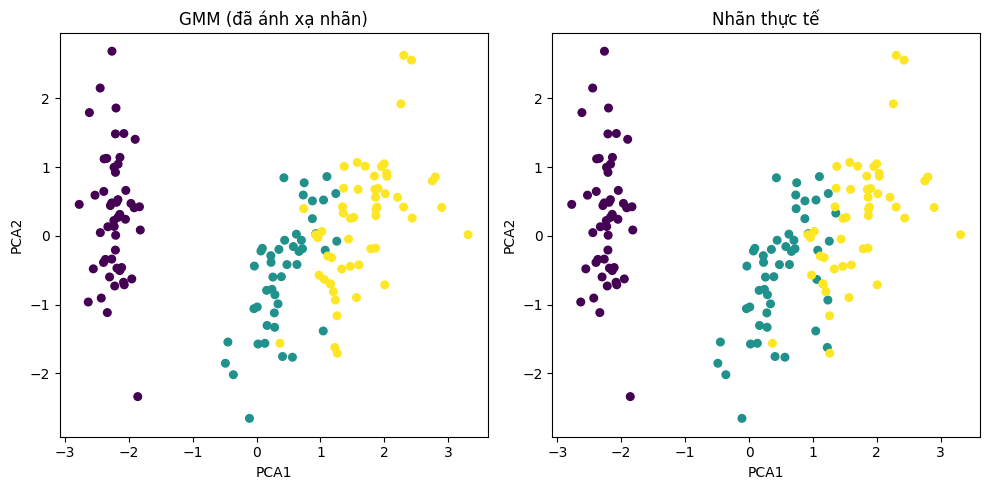

In [90]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_aligned, cmap="viridis", s=30)
plt.title("GMM (đã ánh xạ nhãn)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap="viridis", s=30)
plt.title("Nhãn thực tế")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

plt.tight_layout()
plt.show()


### Bài tập tự thực hành 2: Hãy sử dụng thuật toán K-means để phân cụm dữ liệu tự tạo đã có trong ví dụ 1 của phần này. So sánh và giải thích kết quả.

###### Import & generate data

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-20, 20]):
    np.random.seed(42)
    x = []
    mean = np.random.rand(k, dim) * (lim[1] - lim[0]) + lim[0]

    for i in range(k):
        cov = np.random.rand(dim, dim+5)
        cov = np.matmul(cov, cov.T)  # tạo covariance chắc chắn PSD
        cluster_pts = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x.append(cluster_pts)

    return np.vstack(x)

X_data = gen_data(k=3, dim=2, points_per_cluster=150)
print("Shape:", X_data.shape)



Shape: (450, 2)


###### Visualize dữ liệu gốc

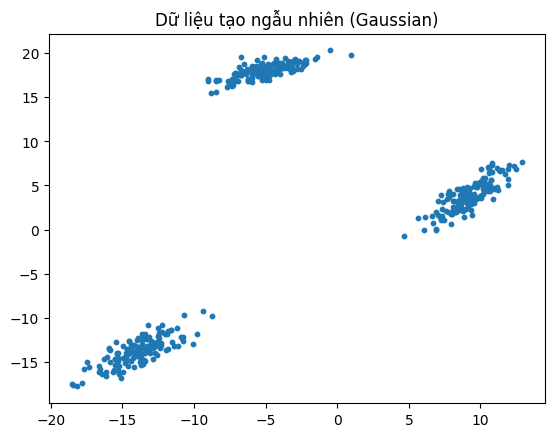

In [92]:
plt.scatter(X_data[:, 0], X_data[:, 1], s=10)
plt.title("Dữ liệu tạo ngẫu nhiên (Gaussian)")
plt.show()


###### K-means Clustering

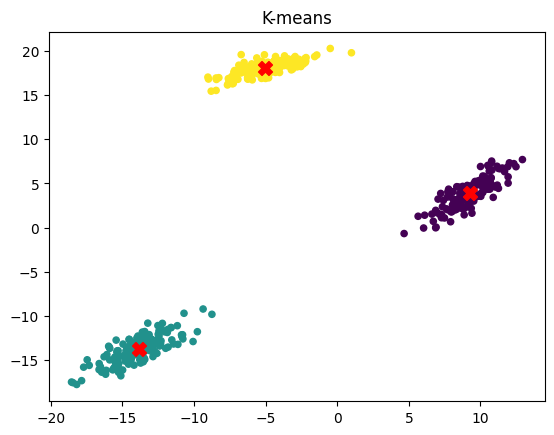

In [93]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(X_data)
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_kmeans, s=20, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=100, c='red', marker='X')
plt.title("K-means")
plt.show()


###### GMM Clustering

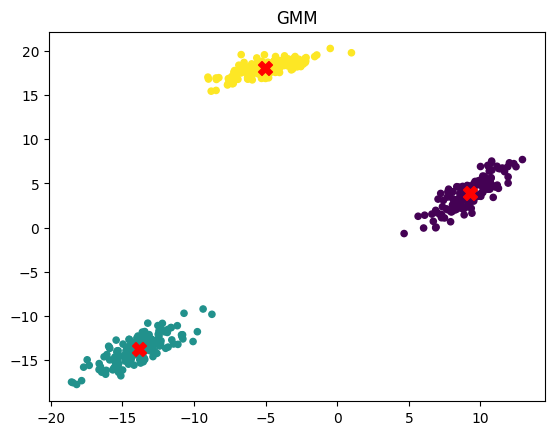

In [94]:
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
y_gmm = gmm.fit_predict(X_data)
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_gmm, s=20, cmap='viridis')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
            s=100, c='red', marker='X')
plt.title("GMM")
plt.show()


###### Evaluation

In [95]:
sil_kmeans = silhouette_score(X_data, y_kmeans)
sil_gmm    = silhouette_score(X_data, y_gmm)

dbi_kmeans = davies_bouldin_score(X_data, y_kmeans)
dbi_gmm    = davies_bouldin_score(X_data, y_gmm)

ch_kmeans = calinski_harabasz_score(X_data, y_kmeans)
ch_gmm    = calinski_harabasz_score(X_data, y_gmm)


###### So sánh bằng biểu đồ

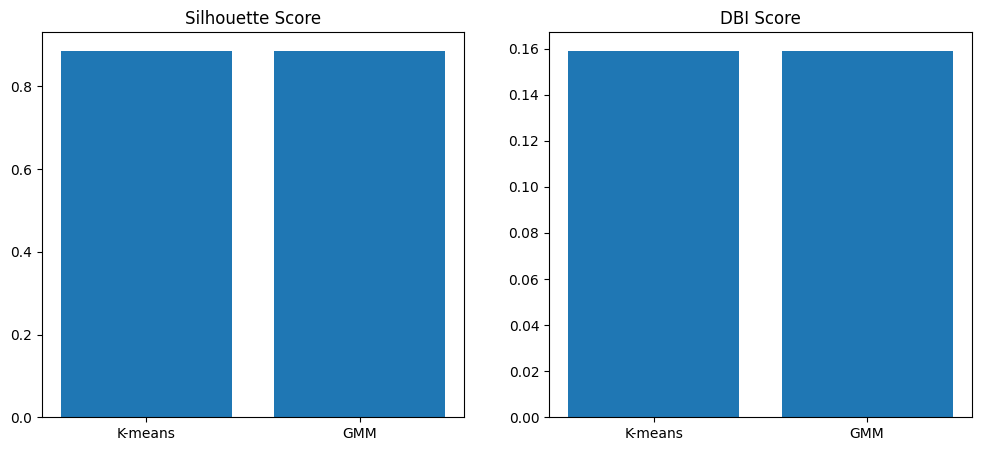

In [96]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.bar(["K-means", "GMM"], [sil_kmeans, sil_gmm])
plt.title("Silhouette Score")

plt.subplot(1, 2, 2)
plt.bar(["K-means", "GMM"], [dbi_kmeans, dbi_gmm])
plt.title("DBI Score")

plt.show()


In [97]:
print("="*45)
print(f"{'Thước đo':<15} | {'K-means':>10} | {'GMM':>10}")
print("-"*45)
print(f"{'Silhouette':<15} | {sil_kmeans:>10.4f} | {sil_gmm:>10.4f}")
print(f"{'DBI':<15}       | {dbi_kmeans:>10.4f} | {dbi_gmm:>10.4f}")
print(f"{'CH Index':<15}  | {ch_kmeans:>10.2f} | {ch_gmm:>10.2f}")
print("="*45)


Thước đo        |    K-means |        GMM
---------------------------------------------
Silhouette      |     0.8863 |     0.8863
DBI                   |     0.1591 |     0.1591
CH Index         |   12149.60 |   12149.60


#### 2.2. Sử dụng thư viện sk-learn

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Ellipse
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture



###### Load dữ liệu & chuẩn hóa

In [99]:
data = pd.read_csv(
    "/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab11/shopping-data.csv",
    header=0,
    index_col=0
)

print(data.shape)
display(data.head())

# Lấy Income + Spending Score
X = data.iloc[:, 2:4].values

# Chuẩn hóa
std = MinMaxScaler()
X_std = std.fit_transform(X)
print("Shape:", X_std.shape)


(200, 4)


,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


Shape: (200, 2)


###### Fit Gaussian Mixture ban đầu

In [100]:
gm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gm.fit(X_std)

print("Means:\n", gm.means_)
print("Covariances:\n", gm.covariances_)


Means:
 [[0.33368985 0.49394756]
 [0.60502531 0.15433196]
 [0.58393969 0.82673863]
 [0.09861098 0.21597752]
 [0.0829305  0.80743088]]
Covariances:
 [[[ 0.00613567 -0.00231927]
  [-0.00231927  0.0051635 ]]

 [[ 0.01818446  0.00433814]
  [ 0.00433814  0.00873064]]

 [[ 0.01808598 -0.00031096]
  [-0.00031096  0.0091568 ]]

 [[ 0.00453005  0.00255303]
  [ 0.00255303  0.01918353]]

 [[ 0.00337483 -0.0001437 ]
  [-0.0001437   0.01026088]]]


###### Tìm số cụm tối ưu bằng BIC

In [101]:
lowest_bic = np.inf
bic = []

n_components_range = range(1, 7)
cv_types = ['full', 'tied']

for cv_type in cv_types:
    for n_components in n_components_range:

        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=cv_type
        )

        gmm.fit(X_std)
        bic.append(gmm.bic(X_std))

        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)


###### Vẽ biểu đồ BIC

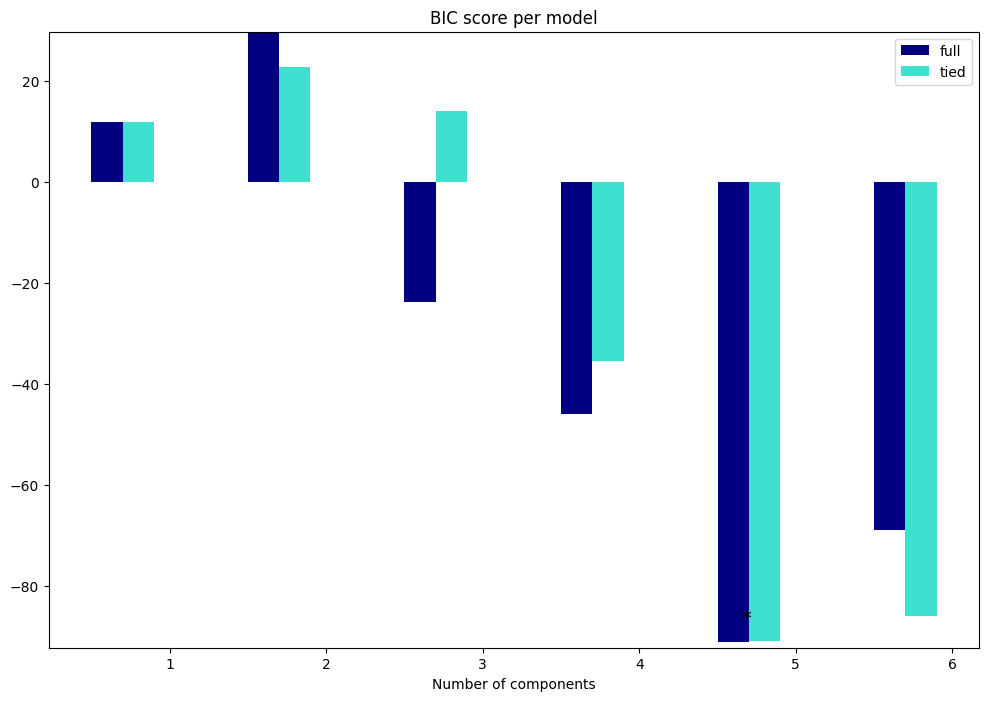

In [102]:
color_iter = itertools.cycle(['navy', 'turquoise'])
bars = []

plt.figure(figsize=(12, 8))

for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + 0.2 * (i - 2)
    bars.append(
        plt.bar(
            xpos,
            bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
            width=0.2,
            color=color
        )
    )

plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - 0.01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = (
    np.mod(bic.argmin(), len(n_components_range)) +
    0.65 +
    0.2 * np.floor(bic.argmin() / len(n_components_range))
)

plt.text(xpos, bic.min() * 0.97 + 0.03 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

plt.show()


###### Hàm vẽ các cụm

In [103]:
def _plot_kmean_scatter(X, labels):
    labels = labels.astype(int)

    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    plt.figure(figsize=(12, 8))
    ax = plt.subplot()

    ax.scatter(
        X[:, 0], X[:, 1],
        lw=0, s=40,
        c=palette[labels]
    )

    for i in range(num_classes):
        xtext, ytext = np.median(X[labels == i], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="white"),
            PathEffects.Normal()
        ])

    plt.title("GMM cluster visualization")
    plt.show()


###### Dự đoán bằng mô hình tốt nhất và vẽ

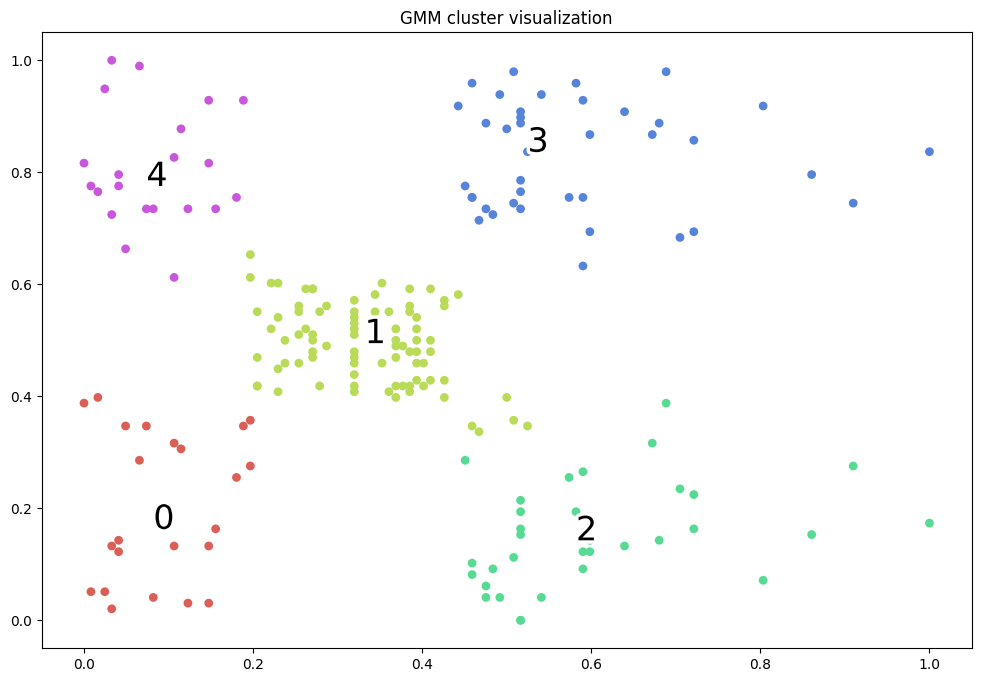

In [104]:
labels = best_gmm.predict(X_std)
_plot_kmean_scatter(X_std, labels)


#### 2.3.Ví dụ mở rộng.

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


In [106]:
df = pd.read_csv("/Users/nguyencongtri/PycharmProjects/MachineLearning/Lab11/Sales_Transactions_Dataset_Weekly.csv")
print(df.shape)
df.head()


(811, 107)


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


###### Lấy dữ liệu giao dịch 52 tuần

In [107]:
weeks = [f"W{i}" for i in range(52)]
X = df[weeks].values
print(X.shape)


(811, 52)


###### Chuẩn hóa dữ liệu

In [108]:
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)
print(X_std.shape)


(811, 52)


###### Tìm số cụm tối ưu (GMM + BIC)

In [109]:
lowest_bic = np.inf
bic = []
n_components_range = range(5, 16)
cv_types = ["full"]

for cv_type in cv_types:
    for n_comp in n_components_range:
        
        gmm = GaussianMixture(
            n_components=n_comp,
            covariance_type=cv_type,
            random_state=0
        )

        gmm.fit(X_std)
        bic_value = gmm.bic(X_std)
        bic.append(bic_value)

        if bic_value < lowest_bic:
            lowest_bic = bic_value
            best_gmm = gmm


###### Vẽ biểu đồ BIC

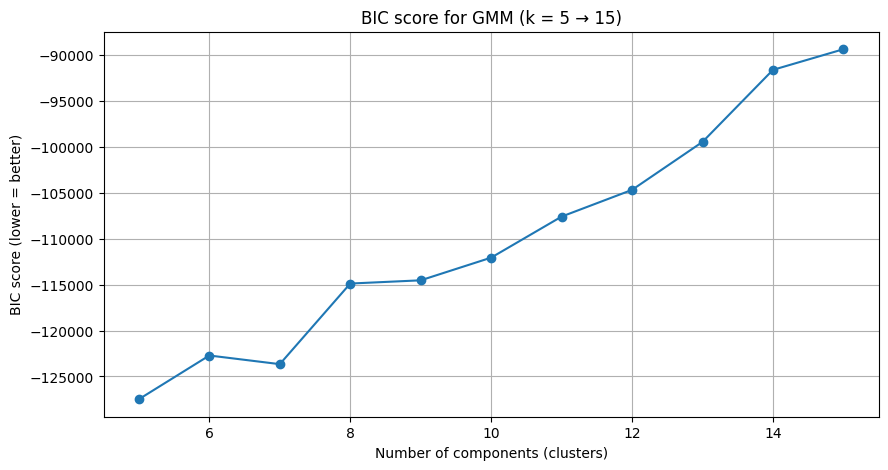

Số cụm tối ưu: 5


In [110]:
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic, marker='o')
plt.title("BIC score for GMM (k = 5 → 15)")
plt.xlabel("Number of components (clusters)")
plt.ylabel("BIC score (lower = better)")
plt.grid(True)
plt.show()

print("Số cụm tối ưu:", best_gmm.n_components)


###### Gán nhãn các cụm cho sản phẩm

In [111]:
labels = best_gmm.predict(X_std)
df["Cluster"] = labels
df.head()


,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51,Cluster
0,P1,11,12,10,8,13,12,14,21,6,...,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39,3
1,P2,7,6,3,2,7,1,6,3,3,...,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00,3
2,P3,7,11,8,9,10,8,7,13,12,...,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36,3
3,P4,12,8,13,5,9,6,9,13,13,...,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35,3
4,P5,8,5,13,11,6,7,9,14,9,...,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40,3


###### Giảm chiều để trực quan hóa (PCA)

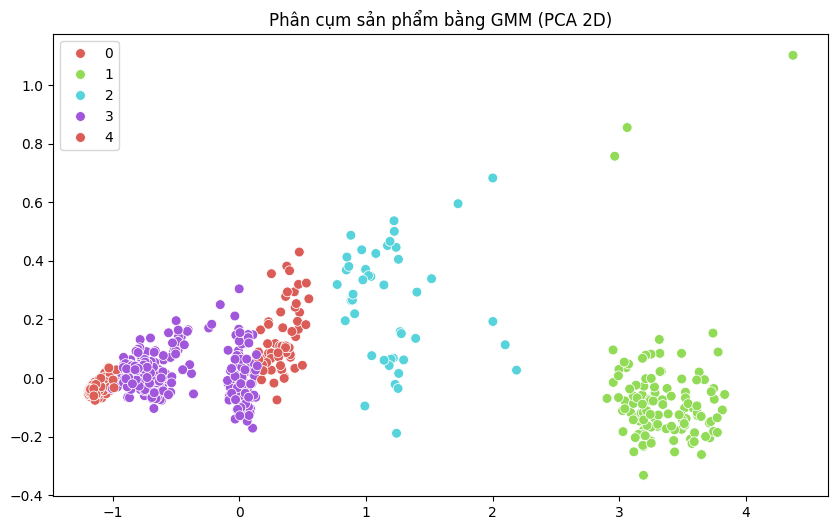

In [112]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=labels,
    palette="hls",
    s=50
)
plt.title("Phân cụm sản phẩm bằng GMM (PCA 2D)")
plt.show()


###### Xuất kết quả cuối cùng

In [113]:
cluster_groups = df.groupby("Cluster")
for c, grp in cluster_groups:
    print(f"\n=== Cụm {c} ===")
    print("Số sản phẩm:", len(grp))



=== Cụm 0 ===
Số sản phẩm: 297

=== Cụm 1 ===
Số sản phẩm: 120

=== Cụm 2 ===
Số sản phẩm: 45

=== Cụm 3 ===
Số sản phẩm: 294

=== Cụm 4 ===
Số sản phẩm: 55
